# EDA Notebook Spring 2023 ML Herbarium

In [ ]:
pip install python-dwca-reader

In [15]:
import requests
import shutil
import os
import time
import math
import pandas
import json
from tqdm import tqdm
import glob
import random
from PIL import Image
import imghdr
from sklearn.model_selection import train_test_split
# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
np.__version__
import matplotlib.pyplot as plt
import cv2


from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn

In [2]:
# Some hyper-parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './data'
width=256
height=256
depth=3


timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "//projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv"
DATASET_PATH = org_img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/"	# "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/"
craft_res_dir = org_img_dir.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = org_img_dir.replace('/scraped-data/', '/seg-results/')

PERCENT_TO_SCRAPE = 0.0006
#PERCENT_TO_SCRAPE = 0.01252703
NUMBER_TO_SKIP = 0
OUTPUT_PATH = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/" + timestr + "/"
TEXT_PATH = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/"
OUTPUT_PATH_IMAGES = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/" + timestr + "/"
DATASET_URL = "https://occurrence-download.gbif.org/occurrence/download/request/0196625-210914110416597.zip"
DATASET_TYPE = ""


Note: There are 7,982,741 images avaialble in GBIF database, but we only scrapped 1198 images for evaluation purpose. If you want to see the amount of data that we have, use the following code, or you can checkout the 'scraping' folder to scrape more data from the website.

```python
# If you want to read the data from that data.csv file
import pandas as pd
df = pd.read_csv(DATASET_PATH + DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")
```



## Converting the CSV data into a pandas data frame

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv(DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,14,16,17,19,21,24,25,26,32,33,34,36,37,38,39,40,41,43,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


colnames: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue']
df.shape: (7982741, 50)


## Taking a look at the data csv

In [4]:
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,2417026544,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027832,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.119Z,StillImage,DIFFERENT_OWNER_INSTITUTION
1,2417026527,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027833,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.120Z,StillImage,DIFFERENT_OWNER_INSTITUTION
2,2458329530,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003877,Plantae,Tracheophyta,Liliopsida,Alismatales,Hydrocharitaceae,Elodea,Elodea canadensis,...,Identified by the collector,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,S.S. Ganeshin,NaN,NaN,2022-03-25T12:48:46.136Z,StillImage,DIFFERENT_OWNER_INSTITUTION
3,2417025838,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027817,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.142Z,StillImage,DIFFERENT_OWNER_INSTITUTION
4,2458328836,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003842,Plantae,Tracheophyta,Liliopsida,Alismatales,Butomaceae,Butomus,Butomus umbellatus,...,Chernyakovskaya-Reyneke,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Chernyakovskaya-Reyneke,NaN,NaN,2022-03-25T12:48:46.168Z,StillImage,DIFFERENT_OWNER_INSTITUTION


## Looking at the most represented genus' in our data (and who collected the species)

In [4]:
x = df['species'].value_counts()
#y = df.pivot(index='genus', columns='species', values=x)
print(f"We have {len(x)} species in total!")
x[:15]

We have 236629 species in total!


Panicum acuminatum         8852
Equisetum arvense          5499
Poa pratensis              5431
Festuca rubra              5374
Deschampsia cespitosa      4808
Poa secunda                4661
Cystopteris fragilis       4653
Pteridium aquilinum        4229
Achillea millefolium       3929
Persicaria lapathifolia    3790
Campanula rotundifolia     3666
Luzula multiflora          3573
Juniperus communis         3455
Juncus bufonius            3450
Persicaria amphibia        3430
Name: species, dtype: int64

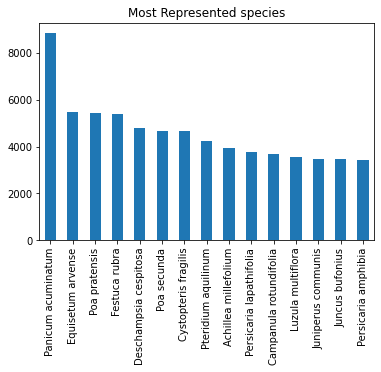

In [5]:
df['species'].value_counts()[:15].plot(kind='bar',title = "Most Represented species");

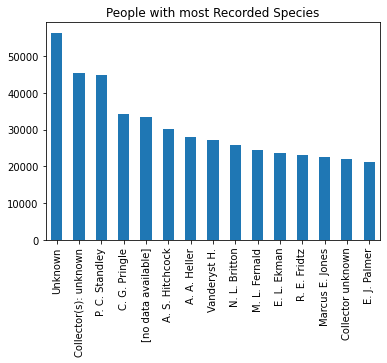

In [6]:
x = df['recordedBy'].value_counts()
x[:15].plot(kind='bar',title = "People with most Recorded Species");

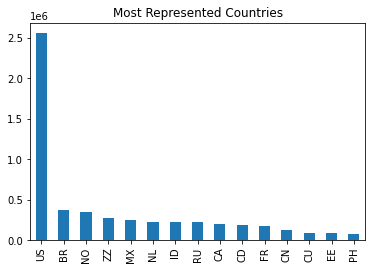

In [7]:
# print(df["countryCode"].describe())
x = df['countryCode'].value_counts()
x[:15].plot(kind='bar',title = "Most Represented Countries");

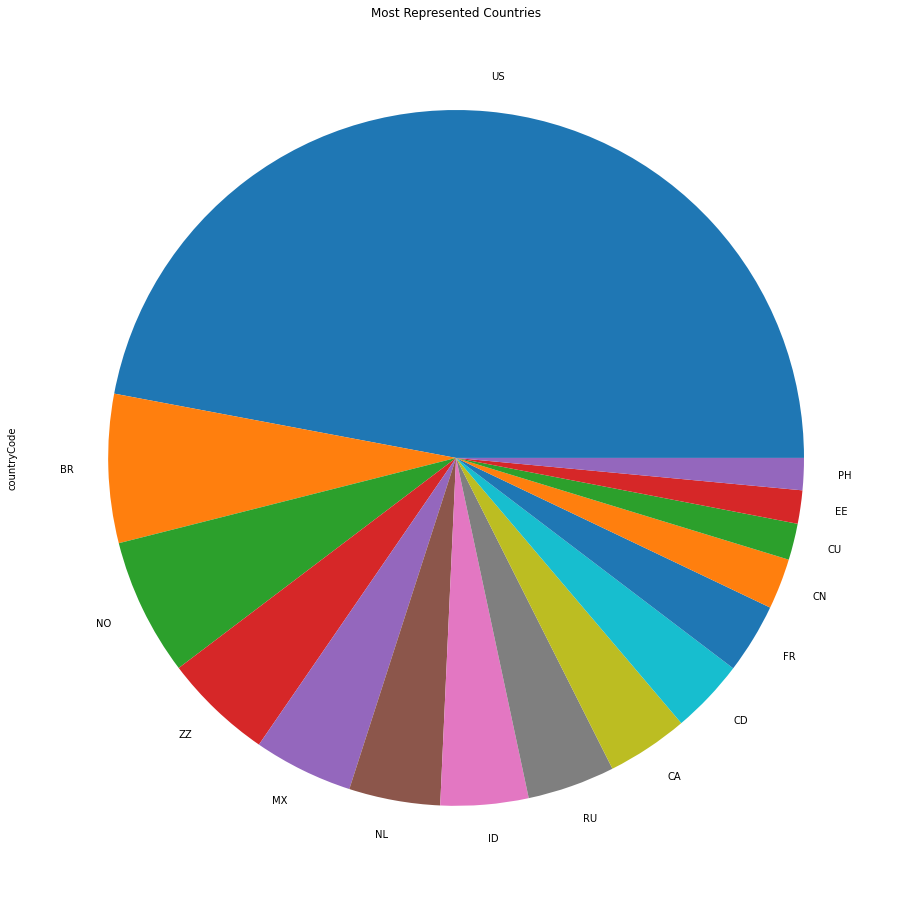

In [8]:
kwargs = dict(

    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 13,
    explode    = (0.1,0.1,0.1),
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Chemotherapy Stratification'
)
df['countryCode'].value_counts()[:15].plot.pie(y=df['countryCode'].unique(), figsize=(24, 16),title = "Most Represented Countries");
# df.plot.pie(y='mass', figsize=(5, 5))

## Extracting the ID values from the dataframe and storing it into a dictionary 'data'

In [21]:
data = {}

NUMBER_TO_SKIP = math.floor(df.shape[0] / (df.shape[0] * PERCENT_TO_SCRAPE))

NUMBER_TO_SCRAPE = math.ceil(df.shape[0] / NUMBER_TO_SKIP) #79
print(str(NUMBER_TO_SCRAPE) + " IDs will be scraped.")
for i in range(1, df.shape[0], NUMBER_TO_SKIP):
#for i in range(1, NUMBER_TO_SCRAPE, NUMBER_TO_SKIP):
    if DATASET_TYPE == "dwca":
        id = df.at[i, "id"]
    elif DATASET_TYPE == "csv":
        id = df.at[i, "gbifID"]
    data[i] = {"id": str(id)}
print("Successfully scraped " + str(len(data)) + " IDs.")


4792 IDs will be scraped.
Successfully scraped 4792 IDs.


# Visualize the ID values

In [ ]:
# Run the following code if you want to visualize the data 
for values in data.values(): 
   print(values)

In [ ]:
#Visualize individual scraped data
#Code to get the dictionary values for a specific key value after extracting the data from the GBIF API
key = 121898
rq = requests.get("https://api.gbif.org/v1/occurrence/" + str(data[key]["id"]))
return_dict = {}
return_dict = json.loads(rq.content)
print(return_dict)
    


## Scrape the data using GBIF API and extract the image URL, taxon, country, Collector information

In [22]:
#code to manually delete the data for corrupted or missing values
from itertools import islice
del data[next(islice(data, 990, None))]
del data[next(islice(data, 3295, None))]
del data[next(islice(data, 3837, None))]
del data[next(islice(data, 3839, None))]
del data[next(islice(data, 4452, None))]


print("Data will be fetched for", len(data), "occurrences.")


def scrape_occurrence(key):
    rq = requests.get("https://api.gbif.org/v1/occurrence/" + str(data[key]["id"]))
    return_dict = {}
    return_dict[key] = {}
    
    if 'media' in json.loads(rq.content):
        if not json.loads(rq.content)["media"]: #checking for empty list
        #print(json.loads(rq.content)["media"][0].keys())
            return None
        else:
            if 'identifier' in json.loads(rq.content)["media"][0]:
                return_dict[key]["img_url"] = json.loads(rq.content)["media"][0]["identifier"]
            else:
                return None
    else:
        return None
        #return_dict[key]["img_url"] = "NAN"
    
    if 'format' in json.loads(rq.content)["media"][0]:
        return_dict[key]["img_type"] = json.loads(rq.content)["media"][0]["format"]
    else:
        return None   
    
    
    if 'country' in json.loads(rq.content):
        return_dict[key]["country"] = json.loads(rq.content)["country"]
    else:
        return None
    
    if 'genus' in json.loads(rq.content):
        return_dict[key]["genus"] = json.loads(rq.content)["genus"]
    else:
        return None
        #return_dict[key]["genus"] = "NAN"
    
    if 'species' in json.loads(rq.content):
        return_dict[key]["species"] = json.loads(rq.content)["species"]
    else:
        return None
    
    if 'recordedBy' in json.loads(rq.content):
        return_dict[key]["Collector"] = json.loads(rq.content)["recordedBy"]
    else:
        return None
    
    #print(return_dict)
    return return_dict

scrape = {}
print("Starting multiprocessing...")
pool = mp.Pool(NUM_CORES)
print("Fetching data...")
#index = 1
for item in tqdm(pool.imap(scrape_occurrence, data), total=len(data)):
    if item==None:
        pass
    else:
        scrape.update(item)
    
pool.close()
pool.join()

print("\nSuccessfully fetched data for", len(scrape), "occurrences.")




Data will be fetched for 4787 occurrences.
Starting multiprocessing...


  0%|          | 0/4787 [00:00<?, ?it/s]

Fetching data...


100%|██████████| 4787/4787 [01:07<00:00, 71.23it/s]



Successfully fetched data for 4447 occurrences.


## Downloading the images and storing them along with Country, Collector and Taxon information

In [23]:
from time import sleep
import requests
import shutil
import multiprocessing as mp
import os
from functools import partial

def download(key):
    try:
        img = requests.get(scrape[key]["img_url"], stream=True, timeout=10)
        with open(
            OUTPUT_PATH_IMAGES + str(key) + "." + scrape[1]["img_type"].split("/", 1)[1], "wb"
        ) as f:
            shutil.copyfileobj(img.raw, f)
        return True, key
    except:
        return False, key

data = scrape.copy()

if not os.path.exists(OUTPUT_PATH_IMAGES):
    os.makedirs(OUTPUT_PATH_IMAGES)

print("Starting multiprocessing...")
pool = mp.Pool(NUM_CORES)
print("Downloading images...")
    #func = partial(download, data=data)
    #errorCount = 0
errorKeys = []
for success, key in tqdm(pool.map(download, scrape), total=len(scrape)):
    if success == False:
        errorKeys.append(key)
pool.close()
pool.join()
for key in errorKeys:
    del scrape[key]
    ## Loop to reindex downloaded images sequentially
    # for count, filename in enumerate(os.listdir(OUTPUT_PATH)):
    #     new = str(count) + "." + filename.split(".")[1]  # new file name
    #     src = os.path.join(OUTPUT_PATH, filename)  # file source
    #     dst = os.path.join(OUTPUT_PATH, new)  # file destination
    #     # rename all the file
    #     os.rename(src, dst)
print("\nSuccessfully downloaded", len(scrape), "images")




Starting multiprocessing...


100%|██████████| 4447/4447 [00:00<00:00, 2269384.34it/s]



Successfully downloaded 4183 images


In [31]:
image_folder = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/20230327-145405/"

# Get the list of image files in the folder
image_files = os.listdir(image_folder)

# Iterate over the dictionary keys and check if the corresponding image file exists
missing_keys = []
for key in data.keys():
    image_filename = str(key) + '.jpg'
    if image_filename not in image_files:
        missing_keys.append(key)
print(f"based on image names we get {len(missing_keys)} keys that had a download failure.")
print("error keys: ",len(errorKeys))
manual_deletion = [key for key in errorKeys if key not in missing_keys]
print("manually delete these images from the created images folder: ",manual_deletion)

based on image names we get 264 keys that had a download failure.
error keys:  264
manually delete these images from the created images folder:  []


## Making a CSV file out of the scraped data

In [32]:
import csv
with open("/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/data.csv", "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Key", "Value"])
    for key, value in scrape.items():
        writer.writerow([key, value])

In [33]:
with open(TEXT_PATH + "countries.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["country"] + "\n")
print("\nSuccessfully wrote countries to file.")


Successfully wrote countries to file.


In [34]:
with open(TEXT_PATH + "taxon.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["genus"] + " " + scrape[idx]["species"] + "\n")
print("\nSuccessfully wrote taxon to file.")


Successfully wrote taxon to file.


In [35]:
with open(TEXT_PATH + "collector.txt", "w") as f:
    for idx in scrape:
        f.write(scrape[idx]["Collector"] + "\n")
print("\nSuccessfully wrote collector to file.")


Successfully wrote collector to file.


## Looking at some of the extracted bounding boxes that are detected by CRAFT

In [9]:
boxes = {}
def addBox(fname):
	if ".jpg" in fname and "mask" not in fname:
		# imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))
		tmp_txt = open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n")[:-1]
		tmp_txt = [line.split(",") for line in tmp_txt]
		tmp_bxs = [[[int(line[i]),int(line[i+1])] for i,val in enumerate(line) if int(i)%2==0] for line in tmp_txt ]
		boxes[fname[4:len(fname)-4]] = tmp_bxs
		return boxes
def fillBoxes():
	print("\nFilling boxes dictionary...")
	print("Starting multiprocessing...")
	list_imgs = sorted(os.listdir(craft_res_dir))
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addBox, list_imgs), total=len(sorted(os.listdir(craft_res_dir)))):
		if item: boxes.update(item)
	pool.close()
	pool.join()
	print("\nBoxes dictionary filled.\n")
# Get all the bounding boxes that segmented by CRAFT
fillBoxes()
print(f"imgIDs that extracted by CRAFT: {boxes.keys()}")


Filling boxes dictionary...
Starting multiprocessing...


100%|██████████| 90/90 [00:00<00:00, 289.18it/s]



Boxes dictionary filled.

imgIDs that extracted by CRAFT: dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


## Let's get all the image ids and store them in a dictionary, with imgID as key, and a img numpy arr as value

In [10]:
img_dict = {}	# Dict<int: imgId, nparr: img>

def addImg(fIdx):
	# By default, cv2.imread() use BGR, if you want to read in grayscale use, cv2.imread('image_1.png', 1)
	temp_img = cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))	
	# convert image form BGR to RGB color for matplotlib
	img_dict[fIdx] = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
	return img_dict

def getOrigImgs():
	print("Getting original images...")
	print("Starting multiprocessing...")
	file_list = sorted(os.listdir(DATASET_PATH))
	imgIds_list = [img[:-4] for img in file_list if ".jpg" in img]
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addImg, imgIds_list), total=len(imgIds_list)):
		img_dict.update(item)
	pool.close()
	pool.join()
	print("\nOriginal images obtained.\n")
getOrigImgs()
img_list = list(img_dict.items())	# a list of Tuple<int: imgId, nparr: img>

Getting original images...
Starting multiprocessing...


100%|██████████| 30/30 [00:05<00:00,  5.21it/s]



Original images obtained.



## Let check the size of each image

In [11]:
def check_img_shape(img_dict):
	# Check image shape for each img item in the img_dict
	shape_list = []
	for key, value in img_dict.items():
		shape_list.append(value.shape)
	print(f"shape_list: {shape_list}")
	return shape_list
print(f"Number of images: {len(img_dict)}")
check_img_shape(img_dict)

Number of images: 30
shape_list: [(2250, 1500, 3), (9101, 6934, 3), (8940, 6771, 3), (1400, 990, 3), (5862, 3411, 3), (5810, 3426, 3), (1144, 1590, 3), (5616, 3744, 3), (5500, 3700, 3), (7100, 4800, 3), (8688, 5792, 3), (8688, 5792, 3), (5616, 3744, 3), (4907, 3399, 3), (8688, 5792, 3), (8955, 6796, 3), (5616, 3744, 3), (1920, 1135, 3), (1920, 1080, 3), (1920, 1169, 3), (1920, 1084, 3), (1920, 1094, 3), (1920, 1188, 3), (9126, 6834, 3), (1600, 1005, 3), (1241, 2000, 3), (5160, 3325, 3), (5110, 3377, 3), (5234, 3281, 3), (1500, 926, 3)]


[(2250, 1500, 3),
 (9101, 6934, 3),
 (8940, 6771, 3),
 (1400, 990, 3),
 (5862, 3411, 3),
 (5810, 3426, 3),
 (1144, 1590, 3),
 (5616, 3744, 3),
 (5500, 3700, 3),
 (7100, 4800, 3),
 (8688, 5792, 3),
 (8688, 5792, 3),
 (5616, 3744, 3),
 (4907, 3399, 3),
 (8688, 5792, 3),
 (8955, 6796, 3),
 (5616, 3744, 3),
 (1920, 1135, 3),
 (1920, 1080, 3),
 (1920, 1169, 3),
 (1920, 1084, 3),
 (1920, 1094, 3),
 (1920, 1188, 3),
 (9126, 6834, 3),
 (1600, 1005, 3),
 (1241, 2000, 3),
 (5160, 3325, 3),
 (5110, 3377, 3),
 (5234, 3281, 3),
 (1500, 926, 3)]

## Let's visualize some sampled images

#### Let's first try out some sample image, and review some OpenCV module first

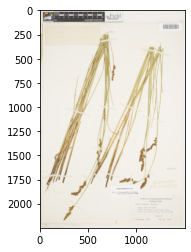

In [12]:
plt.imshow(img_list[0][1]);
# Alternatively, you can use "cv2.imshow('color image',img_color)", but this doesn't allow work for Jupyter Notebook

gray_img: (2250, 1500)


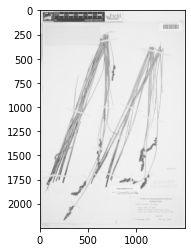

In [13]:
# convert image to grayscale
gray_img = cv2.cvtColor(img_list[0][1], cv2.COLOR_RGB2GRAY);
print(f"gray_img: {gray_img.shape}") # grayscale image represented as a 2-d array

# have to convert grayscale back to RGB for plt.imshow()
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB));

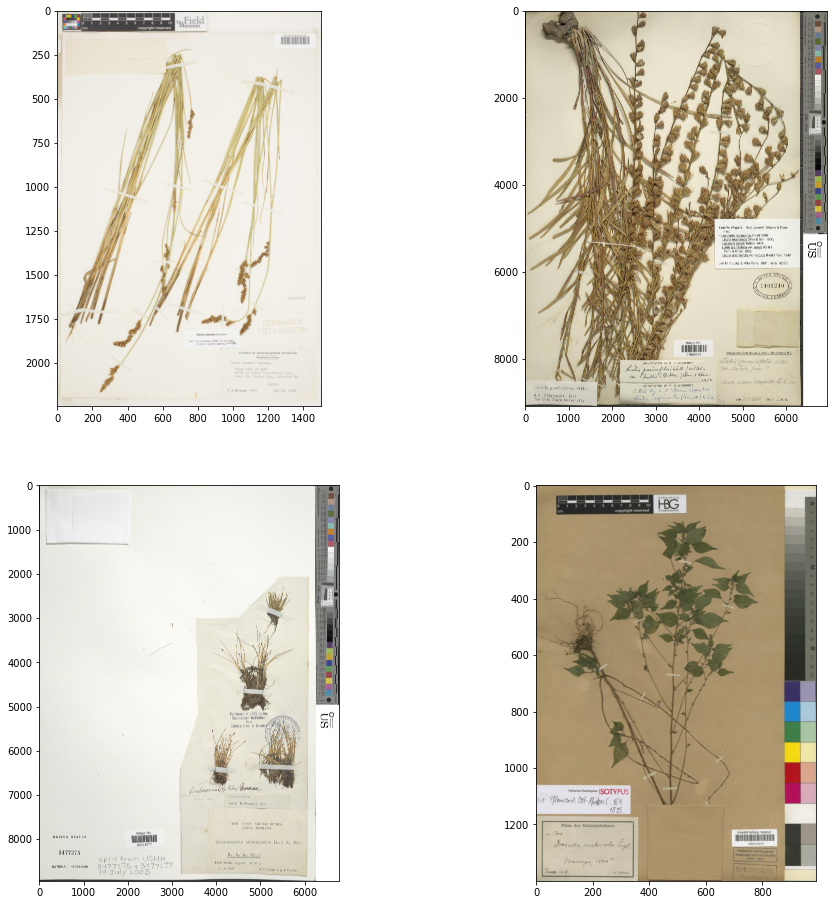

In [14]:
# Visualize the data/images
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrow = 2
ncol = 2
# Set up matplotlib figure, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncol*8, nrow*8)
for i in range(nrow*ncol):
    # Moving subplot index(subplot indices start at 1)
    sp = plt.subplot(nrow, ncol, i + 1)
    # sp.axis('Off') # Don't show axes (or gridlines)
    # Display the images
    plt.imshow(img_list[i][1])
# plt.show()

# Looking at the subset of scrapped images we will be using to test our models

In [ ]:
# Getting the country count for our scrapped testing data from gbif
scrapped_images = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/geography_corpus.txt'
country_count = {}
with open(scrapped_images) as f:
    for line in f:
        line = line.strip()
        if (line in country_count):
            country_count[line] += 1
        else:
            country_count[line] = 1
            
sorted_country = dict(sorted(country_count.items(), key=operator.itemgetter(1),reverse=True))
top_20 = {k: sorted_country[k] for k in list(sorted_country)[:20]}

In [ ]:
#Plotting the top 20 countries for species scans 
plt.bar(top_20.keys(), top_20.values(), width=.4)
plt.xticks(rotation=90)
plt.title('Top 20 Countries of Collection for Scrapped Species Scans');

## Similar to the overall data available from GBIF, the much smaller portion we have scrapped for use testing the models also primarily consists of species scans from the United States. 

In [15]:
#iam traning data 
iam_path_lines = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/lines'
iam_path_sentences = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/sentences'
iam_path_words = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/words'

line_count = len(glob.glob1(iam_path_lines,"*.png"))
sentence_count = len(glob.glob1(iam_path_sentences,"*.png"))
word_count  = len(glob.glob1(iam_path_words,"*.png"))

print('*** IAM Dataset ***')
print('Total number of line traning examples:',line_count)
print('Total number of sentence traning examples:',sentence_count)
print('Total number of word traning examples:',word_count)

*** IAM Dataset ***
Total number of line traning examples: 11344
Total number of sentence traning examples: 14083
Total number of word traning examples: 96456


## One of the things we need to keep in mind as we procede with training and testing the Tr-OCR model is that it might prove useful to train the model on all three sets of handwritten text, as well as other printed text examples. Referencing the "What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis" mentioned in our [research markdown](https://github.com/BU-Spark/ml-herbarium/blob/dev/research.md), the authors stressed the importance of ocr models being exposed to a diverse set of handwritten and printed text during training. Doing so may prove to be the most effective way to increase the overall accuracy of the model. Fourtunately, we have an ample amount of data for each different set of training type in handwritten lines, sentences and words. Examples of each of those handwritten samples is shown below.

Ground Truth Label: defence policy.



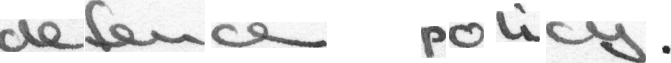

Ground Truth Label: One hopes that he is not asking



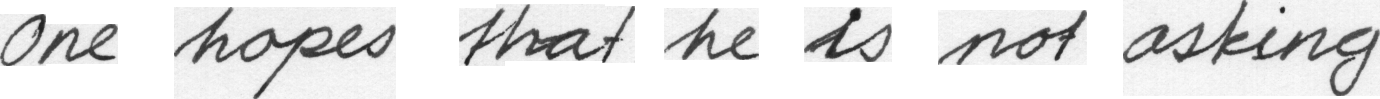

Ground Truth Label: leader



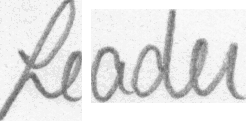

In [16]:
# Examples of the training data for lines available in the IAMA dataset
lines = glob.glob1(iam_path_lines,"*.png")
line = random.choice(lines)
line_img = Image.open(iam_path_lines+'/'+line)
f = open(iam_path_lines+'/'+os.path.splitext(line)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(line_img)

# Examples of the training data for sentences available in the IAMA dataset
sentences = glob.glob1(iam_path_sentences,"*.png")
sentence = random.choice(sentences)
sentence_img = Image.open(iam_path_sentences+'/'+sentence)
f = open(iam_path_sentences+'/'+os.path.splitext(sentence)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(sentence_img)

# Examples of the training data for words available in the IAMA dataset
words = glob.glob1(iam_path_words,"*.png")
word = random.choice(words)
word_img = Image.open(iam_path_words+'/'+word)
f = open(iam_path_words+'/'+os.path.splitext(word)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(word_img)

## Clearly, once the text on these images is segmented, it will be incredibly difficult for the model to pull any relevant information from the image on the left (the smallest scrapped image in our test set). This need for larger images is likely due to the training data consisting of fairly clear words. To illustrate this point, we can look to see what the smallest training examples look like from our training data.

In [18]:
def smallest_file(directory,return_max = False):
    # find the smallest (and largest) png in each of the training datasets
    list_of_files = filter(os.path.isfile,glob.glob(directory+'*.png'))
    
    #Checking image validity
    valid_images = []
    for file in list_of_files:
        if imghdr.what(file) == 'png':
            valid_images.append(file)

    # min from scraped
    min_file = min(valid_images,key =  lambda file: os.stat(file).st_size)
    
    if return_max:
        # max from scraped data
        max_file = max(valid_images,key =  lambda file: os.stat(file).st_size)
        return min_file,max_file
    else:
        return min_file

## Displaying the smallest training examples in the training data from lines, sentences, and words

In [ ]:
#Smallest file in lines
min_file_from_lines = smallest_file(iam_path_lines+'/')
print("Smallest file in lines (in kb):",os.stat(min_file_from_lines).st_size/1000)

#Smallest file in sentences
min_file_from_sentences = smallest_file(iam_path_sentences+'/')
print("Smallest file in sentences (in kb):",os.stat(min_file_from_sentences).st_size/1000)

#Smallest file in words
min_file_from_words = smallest_file(iam_path_words+'/')
print("Smallest file in words (in kb):",os.stat(min_file_from_words).st_size/1000)

In [ ]:
plt.figure(figsize=(20, 10))
plt.suptitle('Smallest Samples from Training Sets');
plt.subplot(1, 3, 1) 
f = open(os.path.splitext(min_file_from_lines)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label: "+truth)
plt.imshow(Image.open(min_file_from_lines).convert("RGB"),interpolation='nearest');
plt.subplot(1,3,2)
f = open(os.path.splitext(min_file_from_sentences)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label: "+truth)
plt.imshow(Image.open(min_file_from_sentences).convert("RGB"),interpolation='nearest');
plt.subplot(1,3,3)
f = open(os.path.splitext(min_file_from_words)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label: "+truth)
plt.imshow(Image.open(min_file_from_words).convert("RGB"));


## For the time being, we will be focusing on the larger images for test purposes. There are possible solutions to this problem, such as super resolution to make the text on the smaller images more readable, but our focus will initially be on dealing with the clearer images. If we are able to get satisfactory results on those scans (which are more represntative of the scans that the Harvard herbarium would have) we can move on to trying to deal with the more pixelated images as a stretch goal. All ETL and data cleaning/preprocessing code has been implemented by previous groups [here](https://github.com/BU-Spark/ml-herbarium/blob/dev/scraping/dataset/datasetscraping.py) and [here](https://github.com/BU-Spark/ml-herbarium/blob/dev/transcription/transcribe_labels.py)

## We are splitting up the IAM data into training, test, and validation splits for use with the Tr-OCR model. All of the files follow the same naming convention for both image and annotation, so we will split them up into 80/10/10 for training, validation, and testing.

In [ ]:
line_data = glob.glob1(iam_path_lines,"*.png")
line_answers = [os.path.splitext(name)[0]+".gt.txt" for name in line_data]
sentence_data = glob.glob1(iam_path_sentences,"*.png")
sentence_answers = [os.path.splitext(name)[0]+".gt.txt" for name in sentence_data]
word_data  = glob.glob1(iam_path_words,"*.png")
word_answers = [os.path.splitext(name)[0]+".gt.txt" for name in word_data]


#Lines
X_train_lines, X_test_lines, y_train_lines, y_test_lines = train_test_split(line_data, line_answers, test_size=0.8, random_state=1)

X_test_lines, X_val_lines, y_test_lines, y_val_lines = train_test_split(X_test_lines, y_test_lines, test_size=0.5, random_state=1)

#Sentences
X_train_sentences, X_test_sentences, y_train_sentences, y_test_sentences = train_test_split(sentence_data, sentence_answers, test_size=0.8, random_state=1)

X_test_sentences, X_val_sentences, y_test_sentences, y_val_sentences = train_test_split(X_test_sentences, y_test_sentences, test_size=0.5, random_state=1)

#Words
X_train_words, X_test_words, y_train_words, y_test_words = train_test_split(word_data, word_answers, test_size=0.8, random_state=1)

X_test_words, X_val_words, y_test_words, y_val_words = train_test_split(X_test_words, y_test_words, test_size=0.5, random_state=1)


## We also want to take a look at the CRAFT and its outputs

In [5]:
boxes = {}
def addBox(fname):
	if ".jpg" in fname and "mask" not in fname:
		# imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))
		tmp_txt = open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n")[:-1]
		tmp_txt = [line.split(",") for line in tmp_txt]
		tmp_bxs = [[[int(line[i]),int(line[i+1])] for i,val in enumerate(line) if int(i)%2==0] for line in tmp_txt ]
		boxes[fname[4:len(fname)-4]] = tmp_bxs
		return boxes
def fillBoxes():
	print("\nFilling boxes dictionary...")
	print("Starting multiprocessing...")
	list_imgs = sorted(os.listdir(craft_res_dir))
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addBox, list_imgs), total=len(sorted(os.listdir(craft_res_dir)))):
		if item: boxes.update(item)
	pool.close()
	pool.join()
	print("\nBoxes dictionary filled.\n")
# Get all the bounding boxes that segmented by CRAFT
fillBoxes()
print(f"imgIDs that extracted by CRAFT: {boxes.keys()}")


Filling boxes dictionary...
Starting multiprocessing...


100%|██████████| 90/90 [00:00<00:00, 10056.14it/s]



Boxes dictionary filled.

imgIDs that extracted by CRAFT: dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


In [6]:
img_dict = {}	# Dict<int: imgId, nparr: img>

def addImg(fIdx):
	# By default, cv2.imread() use BGR, if you want to read in grayscale use, cv2.imread('image_1.png', 1)
	temp_img = cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))	
	# convert image form BGR to RGB color for matplotlib
	img_dict[fIdx] = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
	return img_dict

def getOrigImgs():
	print("Getting original images...")
	print("Starting multiprocessing...")
	file_list = sorted(os.listdir(DATASET_PATH))
	imgIds_list = [img[:-4] for img in file_list if ".jpg" in img]
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addImg, imgIds_list), total=len(imgIds_list)):
		img_dict.update(item)
	pool.close()
	pool.join()
	print("\nOriginal images obtained.\n")
getOrigImgs()
img_list = list(img_dict.items())	# a list of Tuple<int: imgId, nparr: img>

Getting original images...
Starting multiprocessing...


100%|██████████| 30/30 [00:05<00:00,  5.61it/s]



Original images obtained.



## Example segmentations

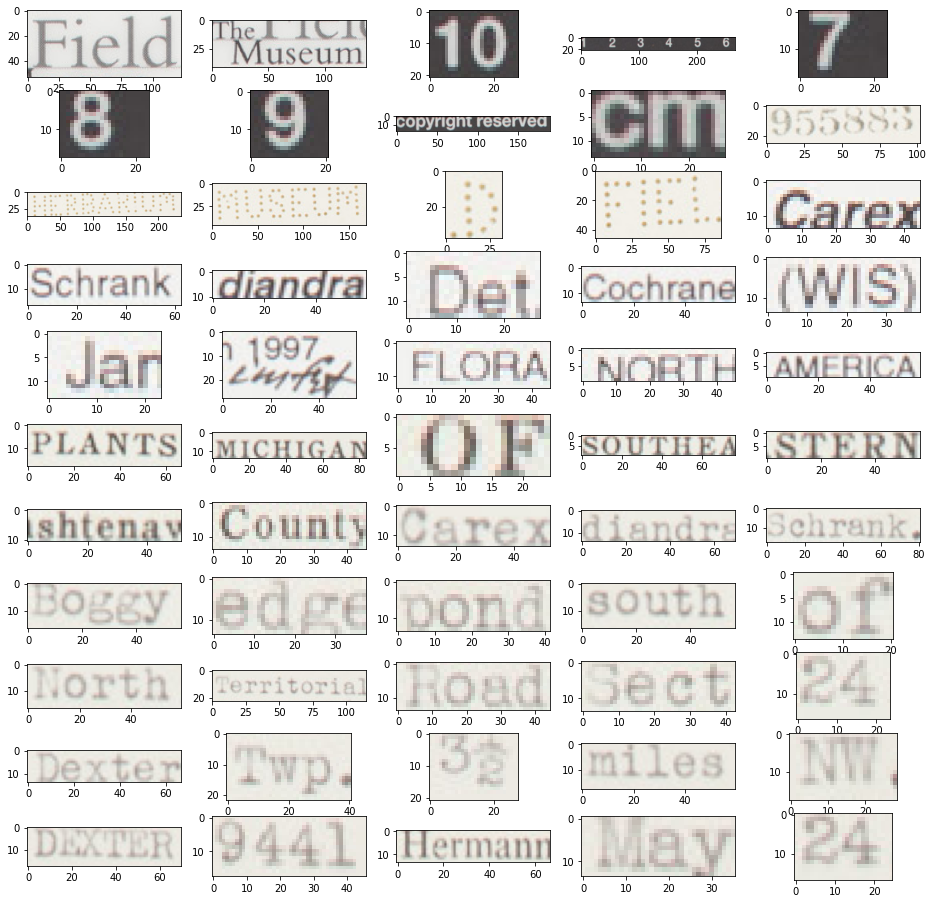

In [7]:
def img_crop(image_num, box_num):
    y = boxes[img_list[image_num][0]][box_num][0][0]
    x = boxes[img_list[image_num][0]][box_num][0][1]
    dy = boxes[img_list[image_num][0]][box_num][2][0] - boxes[img_list[image_num][0]][box_num][0][0]
    dx = boxes[img_list[image_num][0]][box_num][2][1] - boxes[img_list[image_num][0]][box_num][0][1]
    if (x > img_list[image_num][1].shape[0] or y > img_list[image_num][1].shape[1]): return None
    x_crop = img_list[image_num][1][x:x+dx,:,:]
    if x_crop.shape[0] == 0: return None
    y_crop = x_crop[:,y:y+dy,:]
    if y_crop.shape[1] == 0: return None
    return y_crop

fig = plt.gcf()
fig.set_size_inches(2*8, 2*8)
for x in range(len(boxes[img_list[0][0]]) - 1): 
    img = img_crop(0, x)
    plt.subplot(len(boxes[img_list[0][0]])//5, 5, x+1)
    plt.imshow(img)

In [8]:
#extracting boxes into pandas dataframe
df = pd.DataFrame(sum(boxes.values(),[]))
df["width"] = df[2].apply((lambda row:row[0]))- df[0].apply((lambda row:row[0]))
df["height"] = df[2].apply((lambda row:row[1]))- df[0].apply((lambda row:row[1]))
df = df.drop([0,1,2,3], axis=1)
df["area"] = df["width"]*df["height"]
print("Width and Height of First 20 Segmentations")
df.head(20)

Width and Height of First 20 Segmentations


,width,height,area
0,123,53,6519
1,137,42,5754
2,28,21,588
3,267,21,5607
4,24,18,432
5,24,18,432
6,21,18,378
7,190,19,3610
8,28,14,392
9,102,25,2550


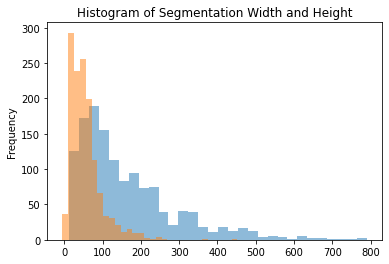

In [9]:
df["width"].plot.hist(bins=30, alpha=0.5);
df["height"].plot.hist(bins=30, alpha=0.5,title = 'Histogram of Segmentation Width and Height');

## The image segmentations produced by craft tend to either be a single word or two words. This is another thing to keep in mind as we train the Tr-OCR model. 